# Train a scVI model using Anncollection dataloader wrapper

In this tutorial we will show how to apply the annCollection wrapper in scvi-tools to load and train SCANVI model on several adata's that are stored on disk

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [2]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

In [198]:
import tempfile
from pathlib import Path

import anndata
import gdown
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
import torch
from anndata.experimental import AnnCollection
from scipy import sparse as sp
from scvi.dataloaders import CollectionAdapter

In [4]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.3.2


In [5]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

We will use 2 types of datasets : PBMC and Covid data, both from SCVI datasets repo

In [6]:
# the data is from this scvi reproducibility notebook
# https://yoseflab.github.io/scvi-tools-reproducibility/scarches_totalvi_seurat_data/
if Path("./pbmc_seurat_v4.h5ad").exists() and Path("./covid_cite.h5ad").exists():
    print("Data already downloaded")
else:
    gdown.download(
        url="https://drive.google.com/uc?id=1X5N9rOaIqiGxZRyr1fyZ6NpDPeATXoaC",
        output="pbmc_seurat_v4.h5ad",
        quiet=False,
    )
    gdown.download(
        url="https://drive.google.com/uc?id=1JgaXNwNeoEqX7zJL-jJD3cfXDGurMrq9",
        output="covid_cite.h5ad",
        quiet=False,
    )

Data already downloaded


## Preprocessing of the data

In [132]:
covid = sc.read("covid_cite.h5ad")
pbmc = sc.read("pbmc_seurat_v4.h5ad")

In [133]:
pbmc.obs["dataset"] = "pbmc"

In [134]:
covid.obs["dataset"] = "covid"

In [135]:
# take annotations from the `pbmc` dataset and leave annotations in `covid` as an Unknown (test)
covid.obs["celltype.l1"] = "Unknown"

Note covid datasets has more genes than the pbmc. We manualy inersect the correct genes.

In [136]:
covid = covid[:, list(pbmc.var.index)]

In [137]:
# create a fake counts layer to test training
covid.layers["test"] = covid.X.copy()
pbmc.layers["test"] = pbmc.X.copy()
covid.raw = covid
pbmc.raw = pbmc

/tmp/ipykernel_886888/3302453168.py:2: ImplicitModificationWarning: Setting element `.layers['test']` of view, initializing view as actual.
  covid.layers["test"] = covid.X.copy()


In [139]:
covid

AnnData object with n_obs × n_vars = 57669 × 20729
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.4', 'seurat_clusters', 'set', 'Resp', 'disease', 'subj_code', 'covidpt_orhealth', 'mito', 'ncount', 'nfeat', 'bust_21', 'og_clust', 'severmod_other', 'og_clusts', 'nCount_ADT', 'nFeature_ADT', 'UMAP1', 'UMAP2', 'final_clust', 'final_clust_v2', 'new_pt_id', 'Resp_og', 'final_clust_withnum', 'final_clust_review', 'Age', 'Gender', 'Gender_num', 'dataset', 'celltype.l1'
    obsm: 'pro_exp'
    layers: 'test'

In [140]:
pbmc

AnnData object with n_obs × n_vars = 161764 × 20729
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'X_index', 'dataset'
    obsm: 'protein_counts'
    layers: 'test'

In [141]:
# create an AnnCollection on a subset of the data
# we're subsetting purely for speed
adata = AnnCollection(
    [covid, pbmc],
    join_vars="inner",
    join_obs="inner",
    label="dataset",
)
adata

AnnCollection object with n_obs × n_vars = 219433 × 20729
  constructed from 2 AnnData objects
    view of layers: 'test'
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'dataset', 'celltype.l1'

In [142]:
collection_adapter = CollectionAdapter(adata)
collection_adapter

Adapter for:
AnnCollection object with n_obs × n_vars = 219433 × 20729
  constructed from 2 AnnData objects
    view of layers: 'test'
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'dataset', 'celltype.l1'

In [143]:
collection_adapter.adatas[0].X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 119919378 stored elements and shape (57669, 20729)>

But in this case we will run HVG selection first for both adatas together

In [144]:
# have an object of 2 adatas from the collection concatenated together
adatas = anndata.concat([collection_adapter.adatas[0], collection_adapter.adatas[1]])

we will do the usuall HVG selection and count transformation on the data

In [145]:
sc.pp.filter_genes(adatas, min_counts=3)

In [146]:
sc.pp.normalize_total(adatas, target_sum=1e4)
sc.pp.log1p(adatas)

In [151]:
sc.pp.highly_variable_genes(
    adatas,
    n_top_genes=1000,
    subset=True,
    layer="test",
    flavor="seurat_v3",
    batch_key="dataset",
)

In [152]:
adatas

AnnData object with n_obs × n_vars = 219433 × 1000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'dataset', 'celltype.l1'
    var: 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg'
    layers: 'test'

We can now save the adatas to disk to be used in anncollection

In [158]:
adatas[adatas.obs.dataset == "covid"]

View of AnnData object with n_obs × n_vars = 57669 × 1000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'dataset', 'celltype.l1'
    var: 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg'
    layers: 'test'

In [160]:
adatas[adatas.obs.dataset == "pbmc"].write("pbmc_subset.h5ad")

/home/access/miniconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/access/miniconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [161]:
adatas[adatas.obs.dataset == "covid"].write("covid_subset.h5ad")

/home/access/miniconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/access/miniconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


## Reload data after preprocessing into an AnndataCollection

In [163]:
# we load the adataq in backed disk mode
covid_subset = sc.read("covid_subset.h5ad", backed="r")
pbmc_subset = sc.read("pbmc_subset.h5ad", backed="r")

Note that our count data is in a sparse form, which is the only one supported currently when using the AnnCollection Wrapper in SCVI-Tools

In [172]:
# create an AnnCollection on a subset of the adata's
adata = AnnCollection(
    [covid_subset, pbmc_subset],
    join_vars="inner",
    join_obs="inner",
    label="dataset",
)
print(adata)

AnnCollection object with n_obs × n_vars = 219433 × 1000
  constructed from 2 AnnData objects
    view of layers: 'test'
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'dataset', 'celltype.l1'


### Build a wrapper AnnData around the collection

In [173]:
collection_adapter = CollectionAdapter(adata)
collection_adapter

Adapter for:
AnnCollection object with n_obs × n_vars = 219433 × 1000
  constructed from 2 AnnData objects
    view of layers: 'test'
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'dataset', 'celltype.l1'

In [174]:
sp.issparse(collection_adapter.layers["test"])

True

In [175]:
scvi.model.SCANVI.setup_anndata(
    collection_adapter,
    layer="test",
    batch_key="dataset",
    labels_key="celltype.l1",
    unlabeled_category="Unknown",
)

In [176]:
model = scvi.model.SCANVI(collection_adapter, n_latent=10)

In [177]:
# we're only training for a few epochs to show it works
model.train(max_epochs=25, early_stopping=True)

INFO     Training for 5 epochs.                                                                                    


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/access/miniconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/home/access/miniconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argume

Training:   0%|          | 0/5 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [178]:
SCANVI_LATENT_KEY = "X_scanVI"
latent = model.get_latent_representation()
latent.shape

(219433, 10)

In [179]:
adatas.obsm[SCANVI_LATENT_KEY] = latent

Generate predictions that will include the covid unknown cells types

In [183]:
predictions = model.predict(collection_adapter)

In [184]:
adatas.obs["predictions_scanvi"] = predictions

Lets compare the PCA vs SCANVI Integrations UMAP results

In [180]:
# run PCA then generate UMAP plots
sc.tl.pca(adatas)
sc.pp.neighbors(adatas, n_pcs=30, n_neighbors=20)
sc.tl.umap(adatas, min_dist=0.3)

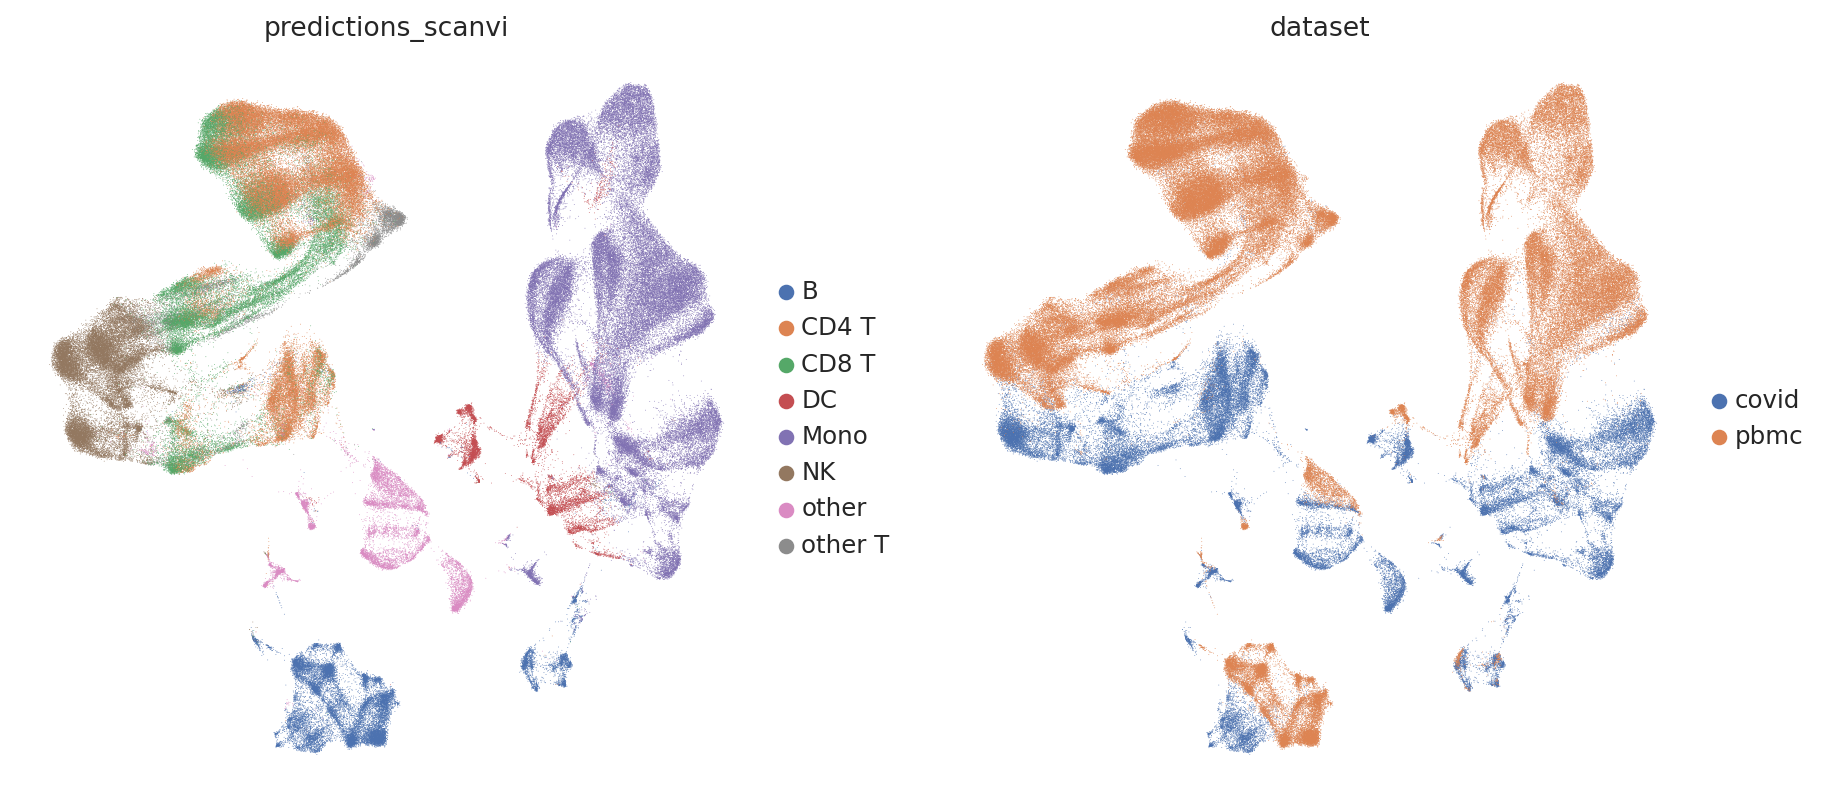

In [187]:
sc.pl.umap(
    adatas,
    color=["predictions_scanvi", "dataset"],
    frameon=False,
)

In [189]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adatas, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adatas, min_dist=0.3)

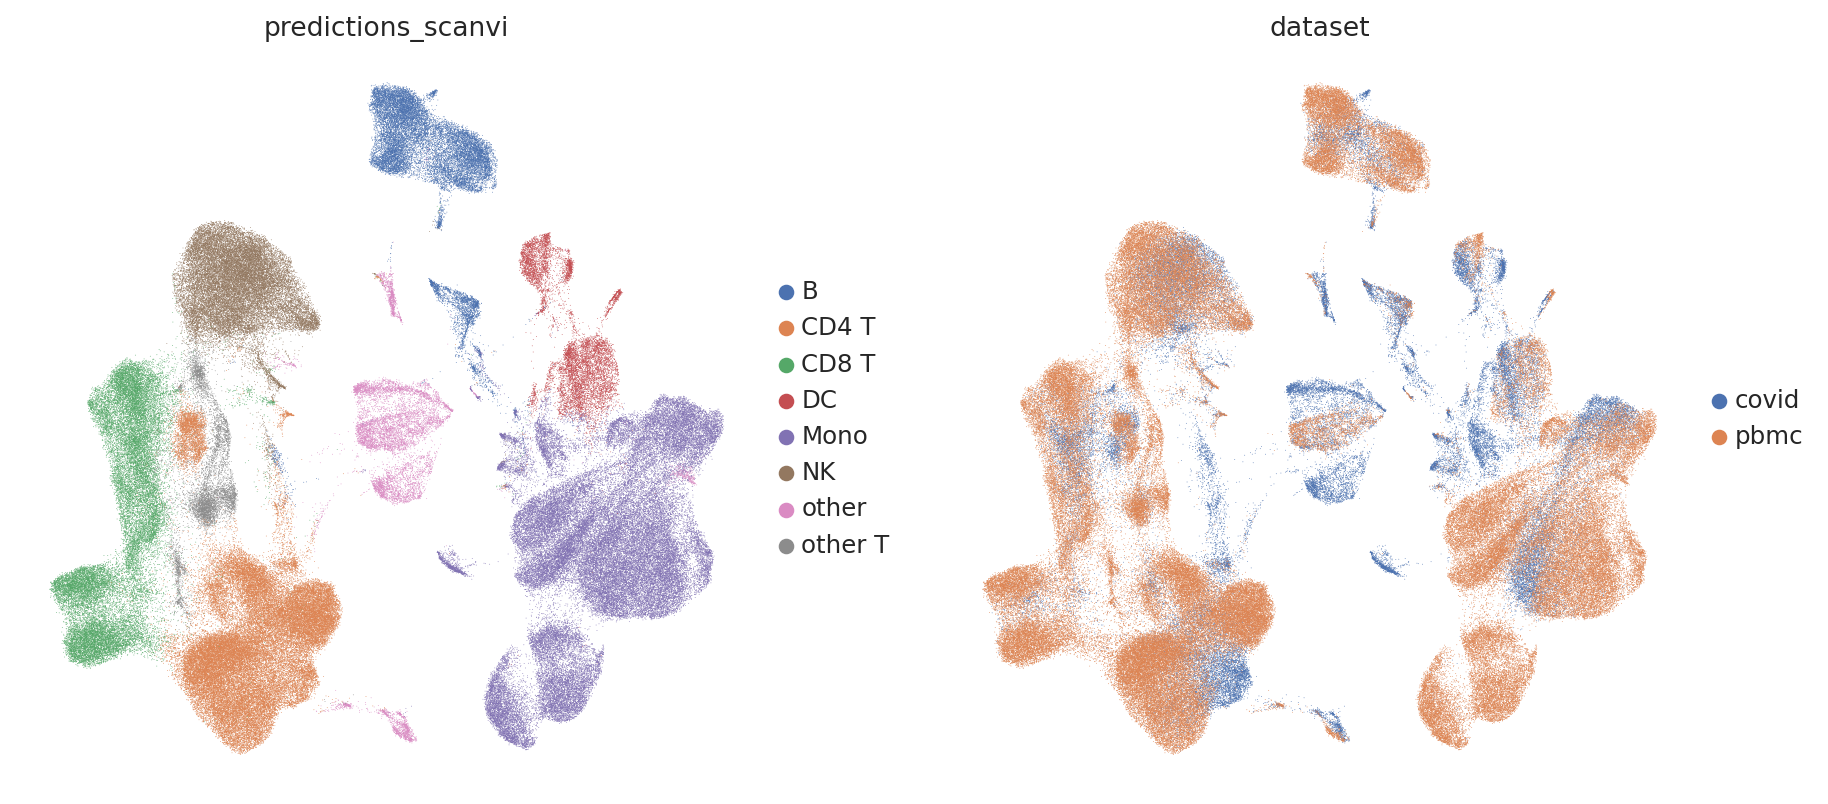

In [190]:
sc.pl.umap(
    adatas,
    color=["predictions_scanvi", "dataset"],
    frameon=False,
)

In [191]:
# neighbors were already computed using scVI
SCVI_CLUSTERS_KEY = "leiden_scVI"
sc.tl.leiden(adatas, key_added=SCVI_CLUSTERS_KEY, resolution=0.5)

/tmp/ipykernel_886888/3118168013.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adatas, key_added=SCVI_CLUSTERS_KEY, resolution=0.5)


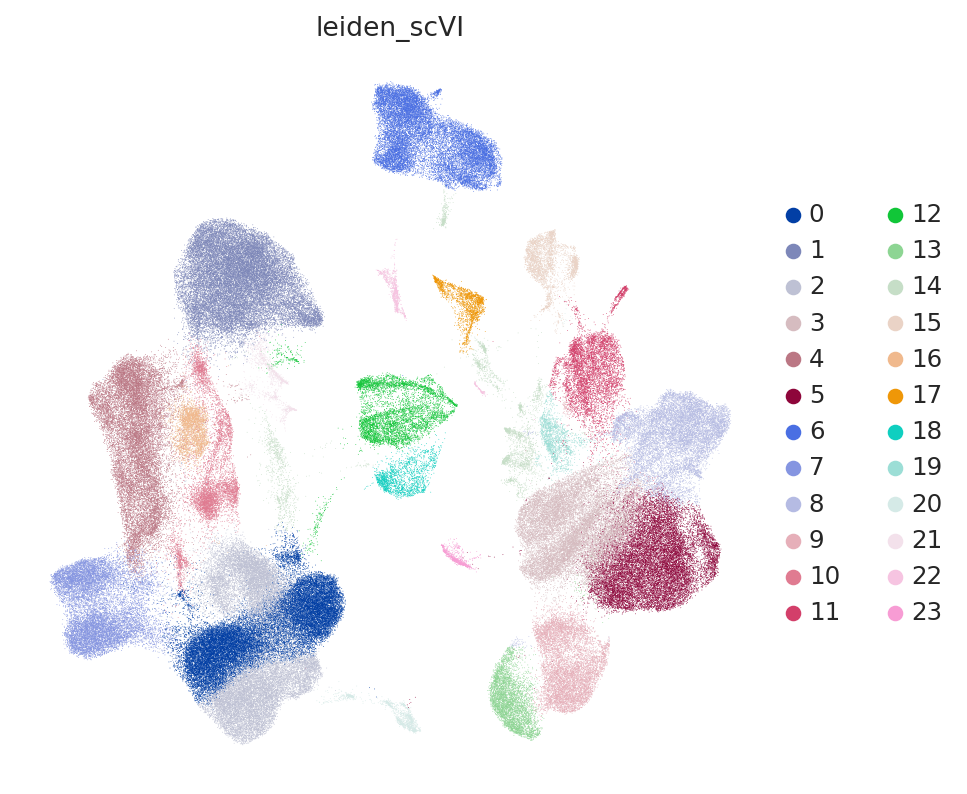

In [192]:
sc.pl.umap(
    adatas,
    color=[SCVI_CLUSTERS_KEY],
    frameon=False,
)

Confusion Matrix

/tmp/ipykernel_886888/1197915929.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = adatas.obs.groupby(["celltype.l1", "predictions_scanvi"]).size().unstack(fill_value=0)


Text(0, 0.5, 'Observed')

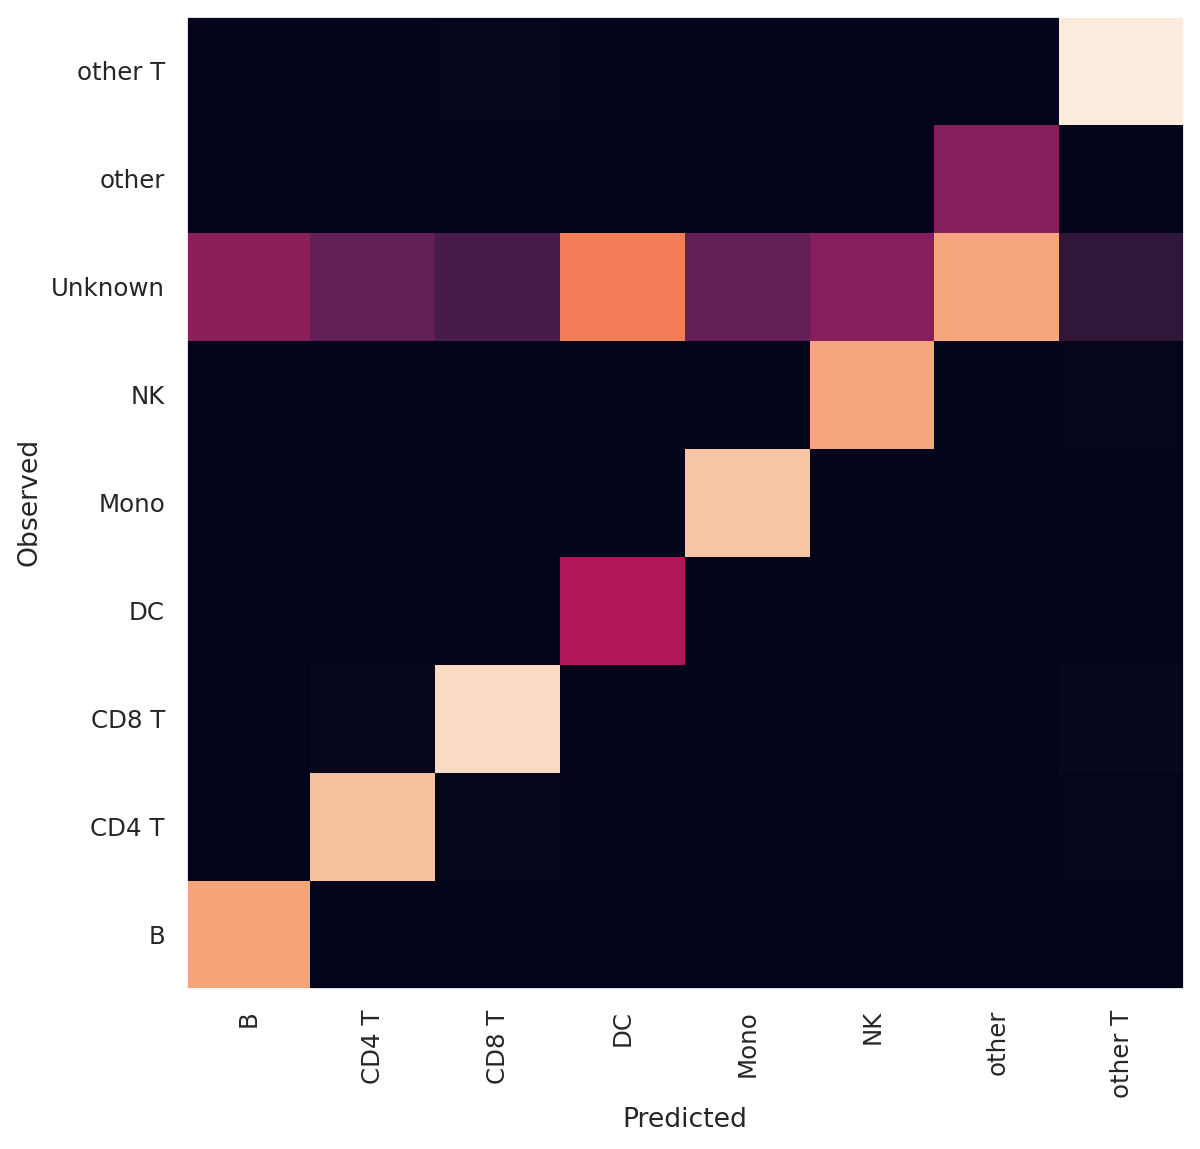

In [188]:
df = adatas.obs.groupby(["celltype.l1", "predictions_scanvi"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

In [203]:
pd.crosstab(adatas.obs["celltype.l1"], adatas.obs["predictions_scanvi"])

predictions_scanvi,B,CD4 T,CD8 T,DC,Mono,NK,other,other T
celltype.l1,,,,,,,,
B,13794,0,1,0,3,1,1,0
CD4 T,2,40709,223,0,5,5,3,54
CD8 T,0,603,24741,0,1,19,2,103
DC,0,0,0,3488,99,0,2,0
Mono,1,2,1,19,48975,0,12,0
NK,0,13,52,0,0,18528,2,69
Unknown,5850,11506,4878,5865,14061,7577,7150,782
other,2,79,24,2,376,16,2940,3
other T,0,278,219,0,2,59,0,6231


## Compare results

In [216]:
from scib_metrics.benchmark import Benchmarker

bm = Benchmarker(
    adatas[list(np.random.choice(np.arange(adatas.n_obs), size=10000, replace=False)), :],
    batch_key="dataset",
    label_key="predictions_scanvi",
    embedding_obsm_keys=["X_pca", "X_scanVI"],
    n_jobs=-1,
)
bm.benchmark()

/home/access/miniconda3/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:439: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/home/access/miniconda3/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:379: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
Metrics:  60%|█████████████████████████▏                | 6/10 [00:21<00:17,  4.27s/it, Batch correction: kbet_per_label]

INFO     8 clusters consist of a single batch or are too small. Skip.                                              


/home/access/miniconda3/lib/python3.12/site-packages/scib_metrics/metrics/_kbet.py:212: RuntimeWarning: Mean of empty slice
  final_score = np.nanmean(kbet_scores["kBET"])

Metrics:  70%|██████████████████████████▌           | 7/10 [00:21<00:08,  2.91s/it, Batch correction: graph_connectivity]/home/access/miniconda3/lib/python3.12/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings:  50%|█████████████████████████████████████                                     | 1/2 [00:21<00:21, 21.60s/it]
                                                                                                                         
Metrics:  60%|█████████████████████████▏                | 6/10 [00:17<00:13,  3.46s/it, Batch correction: kbet_per_label]

INFO     8 clusters consist of a single batch or are too small. Skip.                                              


/home/access/miniconda3/lib/python3.12/site-packages/scib_metrics/metrics/_kbet.py:212: RuntimeWarning: Mean of empty slice
  final_score = np.nanmean(kbet_scores["kBET"])

Metrics:  70%|██████████████████████████▌           | 7/10 [00:18<00:07,  2.36s/it, Batch correction: graph_connectivity]/home/access/miniconda3/lib/python3.12/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings: 100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:39<00:00, 19.93s/it]

                                                                                                                         

/home/access/miniconda3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


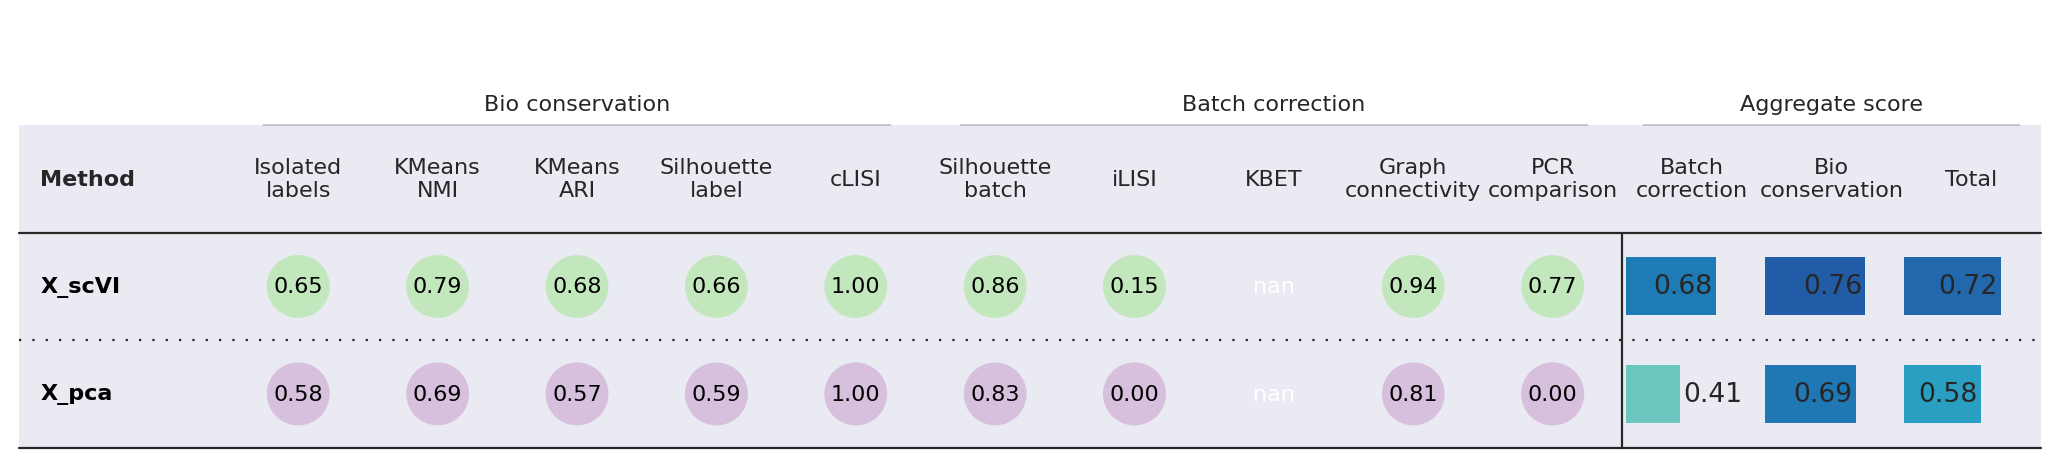

In [217]:
bm.plot_results_table(min_max_scale=False)